# Predicting Sales Prices

 ## Dataset Attributes

 The dataset contains information about houses in Ames, Iowa. The data was collected by the Ames City Assessor’s Office describing 2930 property sales which occurred in Ames, Iowa between 2006 and 2010. The dataset, containing 81 variables, was compiled and published by De Cock in 2011.

 This dataset  contains the following variables:
* **Year_Built:** year that the house was originally constructed
* **Year_Remod_Add:** year that the house was last remodelled
* **Total_Bsmt_SF:** total size of basement area in square feet
* **First_Flr_SF:** size of the first floor in square feet
* **Second_Flr_SF:** size of the second floor in square feet
* **Gr_Liv_Area:** size of above grade, ground living area in square feet
* **Full_Bath:** number of full above grade bathrooms in the house
* **Half_Bath:** number of half above grade bathrooms in the house
* **Bedroom_AbvGr:** number of above grade bedrooms (does not include basement bedrooms)
* **Kitchen_AbvGr:** number of above grade kitchens
* **TotRms_AbvGrd:** total number of above grade rooms (does not include bathrooms)
* **Fireplaces:** number of fireplaces in the house
* **Garage_Area:** size of garage in square feet
* **Sale_Price:** sale price of the house in dollars


*De Cock, D. (2011). "Ames, Iowa: Alternative to the Boston Housing Data as an End of Semester
Regression Project," Journal of Statistics Education, Volume 19, Number 3.*

- https://ww2.amstat.org/publications/jse/v19n3/decock/DataDocumentation.txt
- http://ww2.amstat.org/publications/jse/v19n3/decock.pdf


 ## Objective

 The goal of this task is to analyse the relationship between these variables and build a multiple linear regression model to predict the sales prices based on the 'Gr_Liv_Area' and 'Garage_Area` variables.


In [25]:
# Import libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from scipy.stats import shapiro
from sklearn.metrics import mean_squared_error


In [26]:
# Read in the data set
data = pd.read_csv("ames.csv")
data.sample(5)

,Year_Built,Year_Remod_Add,Total_Bsmt_SF,First_Flr_SF,Second_Flr_SF,Gr_Liv_Area,Full_Bath,Half_Bath,Bedroom_AbvGr,Kitchen_AbvGr,TotRms_AbvGrd,Fireplaces,Garage_Area,Sale_Price
1188,1971,2004,1258,1258,0,1258,2,0,3,1,5,0,528,145000
398,1970,1970,864,864,0,864,1,0,3,1,5,0,660,120500
917,1918,1990,600,628,600,1228,1,0,3,1,6,1,215,137000
2753,2006,2006,1286,1294,0,1294,2,0,2,1,6,1,662,193879
468,2007,2007,1373,1555,0,1555,2,0,2,1,7,1,660,174000


In [27]:
# Clean and pre-process the data if necessary

# Get the number of missing data values per column
missing_values_count = data.isnull().sum()

# Look at the number of missing values 
print('Missing Values:')
print (missing_values_count[:])


Missing Values:
Year_Built        0
Year_Remod_Add    0
Total_Bsmt_SF     0
First_Flr_SF      0
Second_Flr_SF     0
Gr_Liv_Area       0
Full_Bath         0
Half_Bath         0
Bedroom_AbvGr     0
Kitchen_AbvGr     0
TotRms_AbvGrd     0
Fireplaces        0
Garage_Area       0
Sale_Price        0
dtype: int64


There are no missing values in the dataset

In [28]:
#number of zeros in a column
zero_count_per_column = (data == 0).sum()
print("Number of zeros per column:")
print(zero_count_per_column[:])





Number of zeros per column:
Year_Built           0
Year_Remod_Add       0
Total_Bsmt_SF       80
First_Flr_SF         0
Second_Flr_SF     1678
Gr_Liv_Area          0
Full_Bath           12
Half_Bath         1843
Bedroom_AbvGr        8
Kitchen_AbvGr        3
TotRms_AbvGrd        0
Fireplaces        1422
Garage_Area        158
Sale_Price           0
dtype: int64


There are not any houses with zero Gr_Liv_Area and 158 houses with no garage area. I tried dropping houses without a garage from the data and re-running
the model but the R2 or coefficients did not change significantly therefore I re-included as I don't think this is skewing the data.

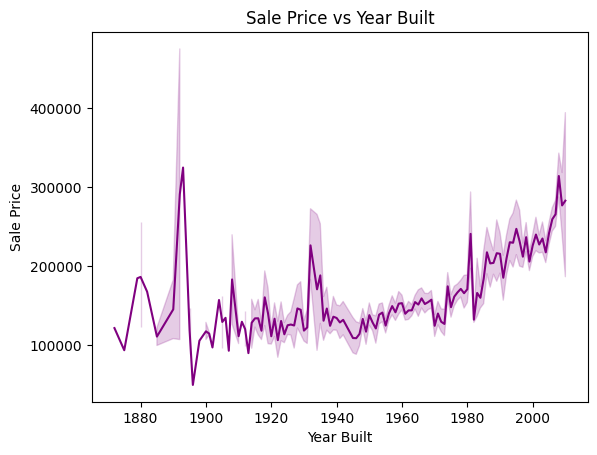

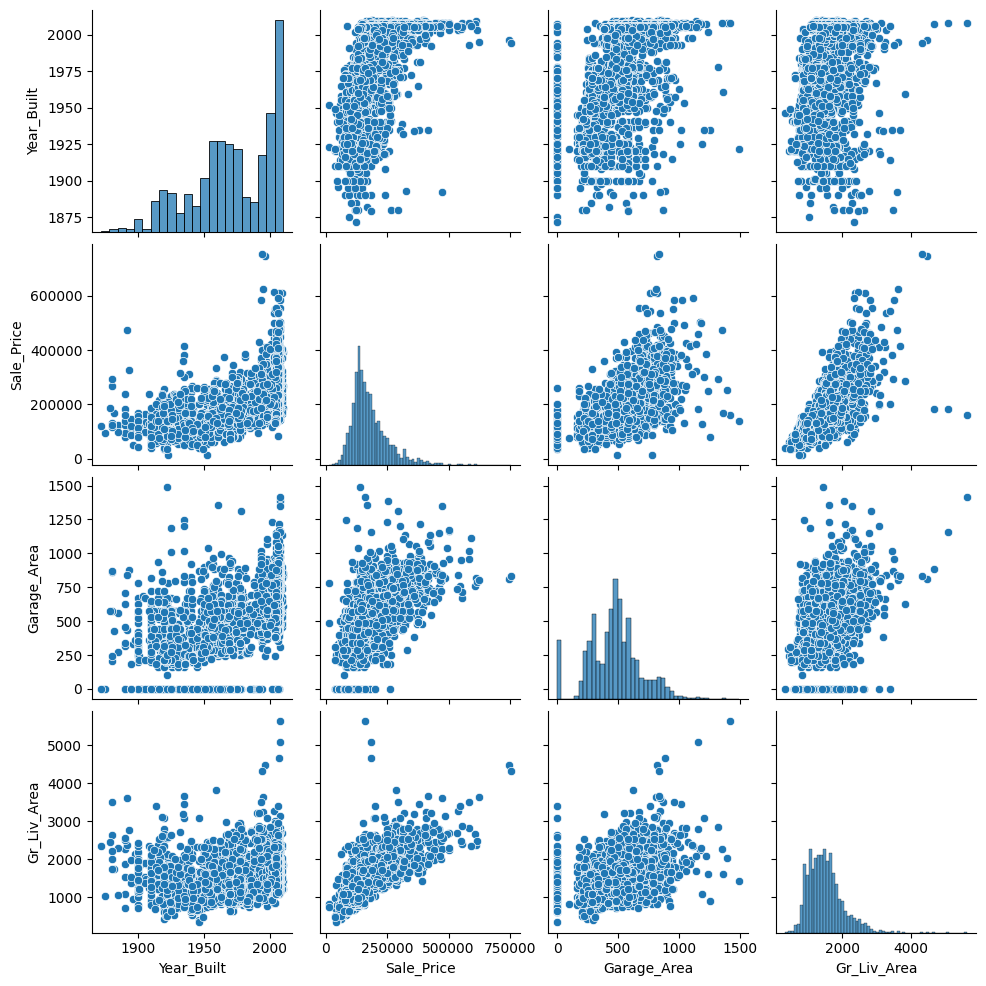

In [29]:
# Explore the data with visualisations such as histograms and correlation matrices
# Lineplot (Sale price with year)

sns.lineplot(x='Year_Built', y='Sale_Price', data = data, color='purple')
plt.xlabel('Year Built')
plt.ylabel('Sale Price')
plt.title('Sale Price vs Year Built')

#Pair plot
sns.pairplot(data = data[['Year_Built', 'Sale_Price', 'Garage_Area', 'Gr_Liv_Area']])



Text(0.5, 1.0, 'Sale Price vs Year Re-modelled')

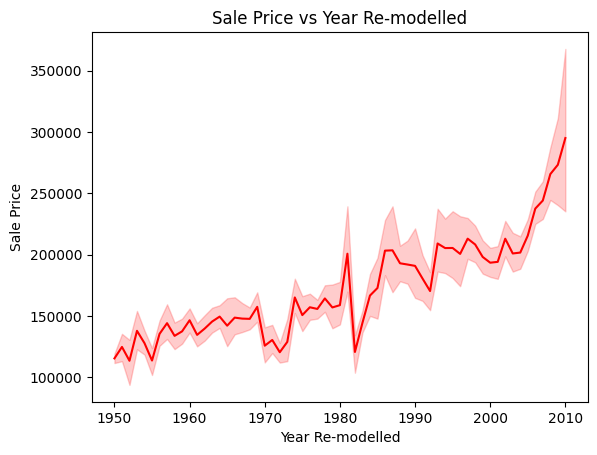

In [30]:

# Lineplot (Sale price with year remodelled)

sns.lineplot(x='Year_Remod_Add', y='Sale_Price', data = data, color='red')
plt.xlabel('Year Re-modelled')
plt.ylabel('Sale Price')
plt.title('Sale Price vs Year Re-modelled')

Text(0.5, 1.0, 'Sale price with number of fireplaces')

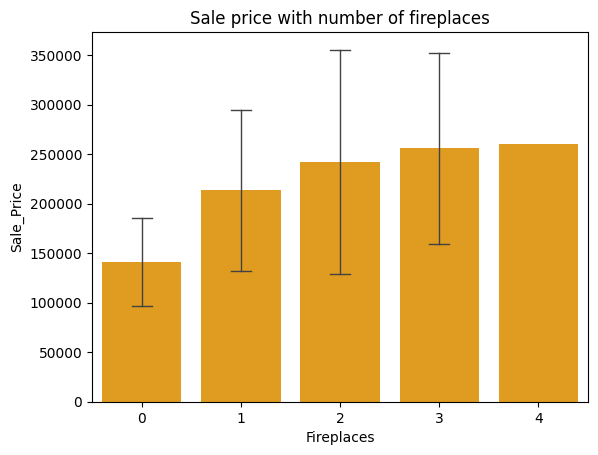

In [31]:
# Bar plot for sales price with different number of fireplaces
sns.barplot(x='Fireplaces', y='Sale_Price', data = data, errorbar='sd', 
            err_kws={'linewidth': 1},capsize =0.2, color='orange') 
plt.title('Sale price with number of fireplaces')


Text(0.5, 1.0, 'Sale price with total number of rooms')

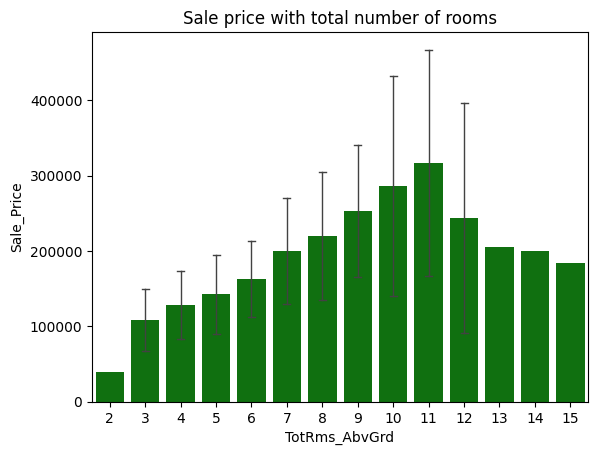

In [32]:
# Bar plot for sales price with different number of total rooms
sns.barplot(x='TotRms_AbvGrd', y='Sale_Price', data = data, errorbar='sd', 
            err_kws={'linewidth': 1},capsize =0.2, color='green') 
plt.title('Sale price with total number of rooms')

Text(0.5, 1.0, 'Sale price with number of full bathrooms')

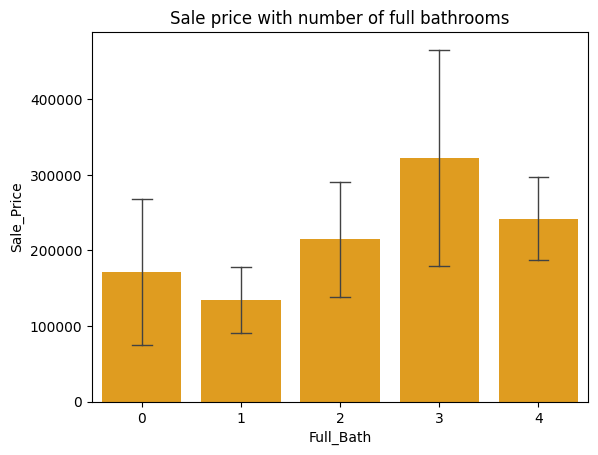

In [33]:
# Bar plot for sales price with different number of full bathrooms
sns.barplot(x='Full_Bath', y='Sale_Price', data = data, errorbar='sd', 
            err_kws={'linewidth': 1},capsize =0.2, color='orange') 
plt.title('Sale price with number of full bathrooms')


In [34]:

# Make function for shapiro-wilkes test then run on my two independent variables 
# To be used in regression. This will determine if data is normalised or standardised

def shapiro_test(my_data):
    stats, p = shapiro(my_data)
    if p > 0.05:
        print(f"The data is normally distributed")
    else:
        print(f"The data is not normally distributed")

print('For Gr_Liv_Area:')
shapiro_test(data['Gr_Liv_Area'])
print('For Garage_Area:')
shapiro_test(data['Garage_Area'])

For Gr_Liv_Area:
The data is not normally distributed
For Garage_Area:
The data is not normally distributed


In [35]:
# Split the dataset into the independent variables and the single dependent variable.

y = data['Sale_Price'].values
x = data.iloc[:,[5,12]].values

 #Re-shape
y = y.reshape(-1, 1)
X = x.reshape(-1, x.shape[1])


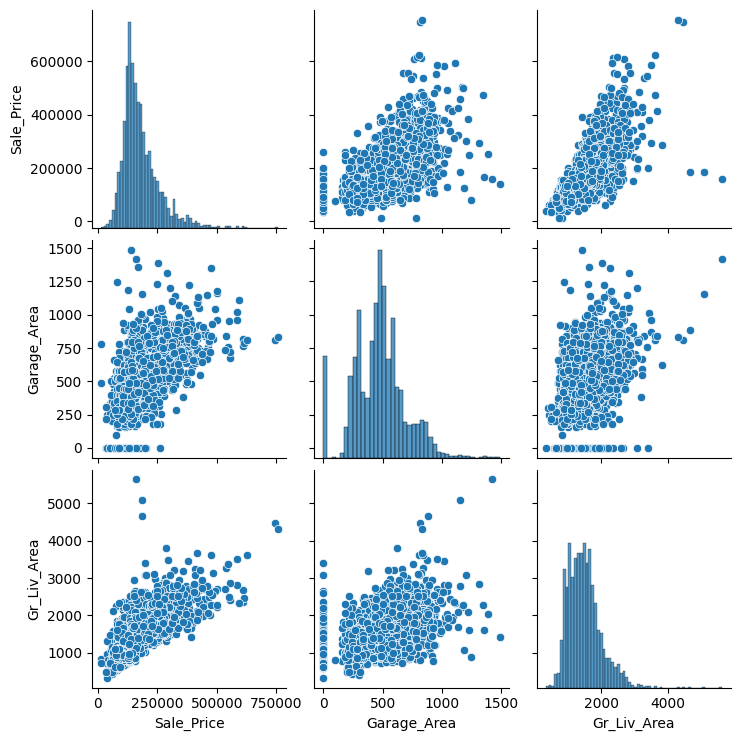

In [36]:
# Explore relationships between the independent and dependent variables
# Pair plot
sns.pairplot(data = data[[ 'Sale_Price', 'Garage_Area', 'Gr_Liv_Area']])

In [37]:
# Create a training and test set with a 75:25 split ratio
rseed = 23 # Use the same random seed for learning purposes to get the same result
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25,  random_state=rseed)

print ("Training data:",X_train.shape, y_train.shape)
print ("Test data:",X_test.shape, y_test.shape)

# Fit the scaler on train data
sc = MinMaxScaler()
sc.fit(X_train)

# Apply the scaler on train and test data
X_train = sc.transform(X_train)
X_test = sc.transform(X_test)

Training data: (2197, 2) (2197, 1)
Test data: (733, 2) (733, 1)


In [38]:
# Build a multiple linear regression model using 'Gr_Liv_Area' and 'Garage_Area'
#
lm = LinearRegression()
model = lm.fit(X_train, y_train)


# Create line coordinates
X_line = np.empty(X_test.shape)
for i in range(X_test.shape[1]):
    X_line[:, i] = np.linspace(np.min(X_test[:,i]), np.max(X_test[:,i]), num=X_test.shape[0])
y_line = lm.predict(X_line)



In [39]:
# Print the model intercept and coefficients
print('Intercept: \n', lm.intercept_)
print('Coefficients: \n', lm.coef_)

Intercept: 
 [19596.191387]
Coefficients: 
 [[403196.70350595 213494.61081906]]


In [40]:
# Generate predictions for the test set
predictions = lm.predict(X_test)

In [41]:
# Evaluate the model
# R squared score
print ("R2 Score:", round (model.score(X_test, y_test),4))

#MSE
rmse = np.sqrt(mean_squared_error(y_test, predictions))

print(f"Root mean squared error: {np.round(rmse, 0)}")

R2 Score: 0.5696
Root mean squared error: 53247.0


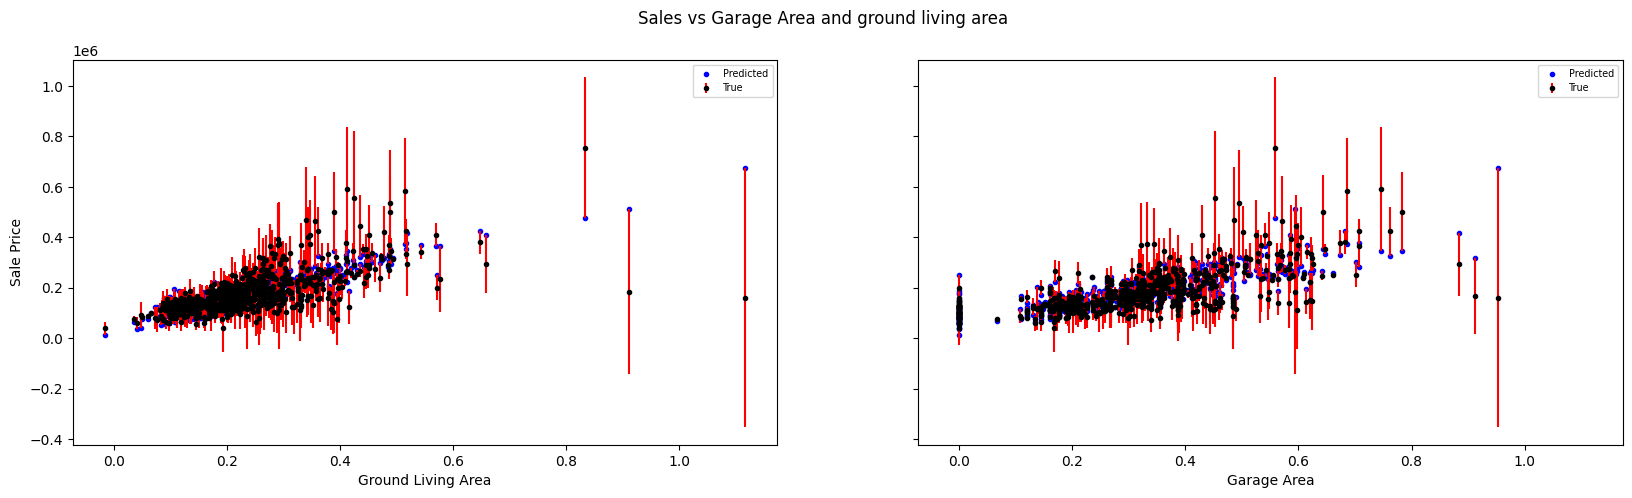

In [42]:
# Generate a plot# Plot the errors
fig, ax = plt.subplots(1, X_test.shape[1], sharey=True, sharex=True, figsize=(20,5))
fig.suptitle("Sales vs Garage Area and ground living area")
ax[0].set_ylabel('Sale Price')
ax[0].set_xlabel('Ground Living Area')
ax[1].set_xlabel('Garage Area')


# Get values for the error bar
error_bar_values = np.abs((y_test-predictions)[:,0])

# Plot data, predicted values, and error bars
for i in range(X_test.shape[1]):
    ax[i].errorbar(X_test[:, i], y_test[:, 0], yerr=error_bar_values, fmt='.k', ecolor='red', label='True')
    ax[i].scatter(X_test[:,i], predictions[:,0], c='b', marker='.', label='Predicted')
    ax[i].legend(loc='best', fontsize='x-small')


In [43]:
# Print the coefficients
print('Coefficients(Ground living area, Garage area): \n', lm.coef_)

Coefficients(Ground living area, Garage area): 
 [[403196.70350595 213494.61081906]]


**Interpret coefficients in the context of the prediction:**
These coefficients show that there is a positive affect of both ground living area and garage area on sale price of a house.
Total ground living area has around double the effect of garage area on the sale price as shown by the coefficient.
The coefficients show the change in sale price with a 1 unit increase, which in this case is moving from the minimum to a maximum
value of each independent variable (the data is scaled).
Moving from the minimum ground living area or garage area to the largest gives an increased sale price of $403197 and $213495 respectively.


**Summarise findings**
In terms of model performance, the R2 score of 0.5696 suggests that around 56.96% of the variance is explained by the model which gives a moderately powerful prediction of sale price but is not perfect. The root mean squared error of 53247 suggests a prediction error of $53247 which is quite high. Looking at the plots of predicted values this error is being increased a lot by some outliers at the larger living/garage areas which have huge differences between the predicted and actual.
The exploratory investigation showed various trends in the data. The line plot showed that there is a general upward trend in sale price with the year built although some there is some houses from pre 1900 that skew this with very high sale prices. Plotting year remodelled with sale price removes the outlier of old houses and shows a strong positive trend with a higher sale price for houses re-modelled in later years. The first bar chart shows that sale price is generally higher with higher numbers of fireplaces although the error bars cross over significantly suggesting this is not a strong predictor of sale price. The second bar chart shows that sale price tends to increase with number of rooms up to a peak of 11 rooms after which it drops again. The error bars are also quite large here.
You can see from the histogram of garage area that houses with zero garages skew the data and stop it from following a normal distribution. These houses with zero garages will impact the intercept of the line of best fit. I tried removing houses without garages from the analysis but this didn't change the data significantly suggesting the intercept would be fairly similar either way.

In [ ]:
# Check for colinearity between independent variables using variance inflation factor

# Import library
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Remind myself of the shape of the data
print(X_train.shape)

# VIF dataframe
vif_data = pd.DataFrame()
vif_data["feature"] = ['Ground Living Area','Garage Area']

# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(X_train, i) for i in range(X_train.shape[1])]
print(vif_data)
                          


(2197, 2)
[[0.2237628  0.2688172 ]
 [0.11668089 0.16129032]
 [0.12713311 0.39516129]
 ...
 [0.48229522 0.48790323]
 [0.08383106 0.        ]
 [0.11049488 0.28830645]]
              feature       VIF
0  Ground Living Area  5.885573
1         Garage Area  5.885573
5.885573318601494
5.88557331860149


The variance inflation factor of 5.9 suggests there may be some degree for colinearity between ground living area and garage area. This value is not above 10 and should not be a major cause for concern. I continue to investigate this VIF by calculating manually below.

In [85]:
# Check for correlation between independent variables before scaling
correlation = pd.DataFrame(X).corr()
print(correlation)

#obtain R^2 from r in the correlation matrix
r_squared = correlation.iloc[0, 1] ** 2
print(f"R-squared value: {r_squared}")



          0         1
0  1.000000  0.483971
1  0.483971  1.000000
R-squared value: 0.23422745164861927


Checking the correlation between my two indepedent variables suggests that they are not highly correlated. This further highlights the lack of colinearity in my multiple regression model.

In [ ]:
# New linear regression model with scaled data between independent variables

X_train_reshaped = X_train[:, 0].reshape(-1, 1)  # Reshape the first feature to 2D
model = lm.fit(X_train_reshaped, X_train[:, 1])  # Fit the model
r_squared = model.score(X_train_reshaped, X_train[:, 1].reshape(-1, 1))  # Calculate R-squared
print(f"R-squared value after scaling: {r_squared}")
# Calculate VIF
vif = 1 / (1 - r_squared)
print(f"VIF: {vif}")

R-squared value after scaling: 0.2250374291469842
VIF: 1.2903849006530488


In this model above I decided to manually create a linear regression between my two independent variables to check the VIF provided by the statsmodel library. Using this model I got a very different VIF of 1.29. This model provided and R2 value of 0.225 which matched the R2 calculated from the correlation coefficient above.